In [1]:
!pip install sentence-transformers

Defaulting to user installation because normal site-packages is not writeable
     |████████████████████████████████| 750.6 MB 27 kB/s                  |███████████████████▊            | 463.1 MB 17.5 MB/s eta 0:00:17█████▍       | 572.1 MB 21.3 MB/s eta 0:00:09�█████      | 612.3 MB 20.3 MB/s eta 0:00:07
  Using cached torch-1.9.0-cp38-cp38-manylinux1_x86_64.whl (831.4 MB)
  Attempting uninstall: torch
    Found existing installation: torch 1.4.0
    Uninstalling torch-1.4.0:
      Successfully uninstalled torch-1.4.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spacybert 1.0.1 requires spacy<3.0.0,>=2.2.1, but you have spacy 3.0.5 which is incompatible.
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.


In [ ]:
conda install pytorch torchvision torchaudio cudatoolkit=10.2 -c pytorch

In [2]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('bert-base-nli-mean-tokens')
#sbert.net

model

SentenceTransformer(
  (0): Transformer({'max_seq_length': 128, 'do_lower_case': False}) with Transformer model: BertModel 
  (1): Pooling({'word_embedding_dimension': 768, 'pooling_mode_cls_token': False, 'pooling_mode_mean_tokens': True, 'pooling_mode_max_tokens': False, 'pooling_mode_mean_sqrt_len_tokens': False})
)

In [4]:
sentences = [
    "the fifty mannequin heads floating in the pool kind of freaked them out",
    "she swore she just saw her sushi move",
    "he embraced his new life as an eggplant",
    "my dentist tells me that chewing bricks is very bad for your teeth",
    "the dental specialist recommended an immediate stop to flossing with construction materials"
]

embedding = model.encode(sentences)
embedding

array([[-0.18893567,  0.18380427, -0.5132157 , ..., -0.9622861 ,
         0.16144875, -0.18547589],
       [-0.0254809 , -0.06504318,  0.85490644, ..., -0.08297264,
        -0.2698283 , -0.09522374],
       [-0.05365554, -0.1009286 ,  0.9991935 , ...,  1.1357747 ,
         0.01794523, -0.24008028],
       [ 0.21320082,  1.8518618 ,  0.36619136, ...,  0.00735281,
         0.3132772 ,  0.41728267],
       [ 0.17712384,  1.5110037 ,  0.96275413, ...,  0.07071581,
        -0.27150536,  0.34254614]], dtype=float32)

In [5]:
embedding.shape

(5, 768)

[[1.00000024 0.         0.         0.         0.        ]
 [0.40914297 1.00000024 0.         0.         0.        ]
 [0.10909013 0.44547984 1.         0.         0.        ]
 [0.50074863 0.30693924 0.20791626 0.99999982 0.        ]
 [0.29936206 0.38607216 0.28499267 0.63849503 1.00000072]]


<AxesSubplot:>

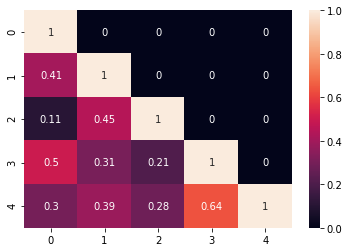

In [19]:
# Semantic Textual Similarity
# Clustering

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers.util import cos_sim

sim = np.zeros((len(sentences),len(sentences)))

for i in range(len(sentences)):
    sim[i:,i] = cos_sim(embedding[i],embedding[i:])
print(sim)
#plt.imshow(sim,cmap='hot',interpolation='nearest')
sns.heatmap(sim,annot=True)

### Training SBERT model 

In [38]:
import datasets

In [72]:

snli = datasets.load_dataset('snli',split='train')

snli 

Reusing dataset snli (/home/majarall/.cache/huggingface/datasets/snli/plain_text/1.0.0/1f60b67533b65ae0275561ff7828aad5ee4282d0e6f844fd148d05d3c6ea251b)


Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 550152
})

In [32]:
mnli = datasets.load_dataset('glue','mnli',split='train')

mnli

Generating train split:   0%|          | 0/392702 [00:00<?, ? examples/s]

Generating validation_matched split:   0%|          | 0/9815 [00:00<?, ? examples/s]

Generating validation_mismatched split:   0%|          | 0/9832 [00:00<?, ? examples/s]

Generating test_matched split:   0%|          | 0/9796 [00:00<?, ? examples/s]

Generating test_mismatched split:   0%|          | 0/9847 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /home/majarall/.cache/huggingface/datasets/glue/mnli/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


Dataset({
    features: ['premise', 'hypothesis', 'label', 'idx'],
    num_rows: 392702
})

In [35]:
mnli 

Dataset({
    features: ['premise', 'hypothesis', 'label'],
    num_rows: 392702
})

In [45]:
#mnli = mnli.remove_columns(['idx'])

snli = snli.cast(mnli.features)

Casting the dataset:   0%|          | 0/56 [00:00<?, ?ba/s]

In [46]:
dataset = datasets.concatenate_datasets([snli,mnli])

In [73]:
dataset = snli 

In [74]:
dataset = dataset.filter(
    lambda x: False if x['label'] == -1 else True)


  0%|          | 0/551 [00:00<?, ?ba/s]

In [75]:
dataset = dataset.select(range(1000))

In [76]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

all_cols = ['label']

for part in ['premise', 'hypothesis']:
    dataset = dataset.map(
        lambda x: tokenizer(
            x[part], max_length=128, padding='max_length',
            truncation=True
        ), batched=True
    )
    for col in ['input_ids', 'attention_mask']:
        dataset = dataset.rename_column(
            col, part+'_'+col
        )
        all_cols.append(part+'_'+col)
print(all_cols)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['label', 'premise_input_ids', 'premise_attention_mask', 'hypothesis_input_ids', 'hypothesis_attention_mask']


In [77]:
import torch 

dataset.set_format(type='torch', columns=all_cols)

# initialize the dataloader

batch_size = 16

loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,shuffle=True)

In [78]:
from transformers import BertModel

# start from a pretrained bert-base-uncased model
model = BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [79]:
# define mean pooling function
def mean_pool(token_embeds, attention_mask):
    # reshape attention_mask to cover 768-dimension embeddings
    in_mask = attention_mask.unsqueeze(-1).expand(
        token_embeds.size()).float()
    # perform mean-pooling but exclude padding tokens (specified by in_mask)
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(
        in_mask.sum(1), min=1e-9
    )
    return pool

In [80]:
ffnn = torch.nn.Linear(768*3, 3)

In [81]:
loss_func = torch.nn.CrossEntropyLoss()
# then later in the code add them to the process
x = loss_func(x, label)  # label is our *true* 0, 1, 2 class

In [82]:
#pytorch Training

from transformers.optimization import get_linear_schedule_with_warmup

# we would initialize everything first
optim = torch.optim.Adam(model.parameters(), lr=2e-5)
# and setup a warmup for the first ~10% steps
total_steps = int(len(dataset) / batch_size)
warmup_steps = int(0.1 * total_steps)
scheduler = get_linear_schedule_with_warmup(
		optim, num_warmup_steps=warmup_steps,
  	num_training_steps=total_steps - warmup_steps)
# then during the training loop we update the scheduler per step
scheduler.step()

In [83]:


from tqdm.auto import tqdm
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# 1 epoch should be enough, increase if wanted
for epoch in range(1):
    model.train()  # make sure model is in training mode
    # initialize the dataloader loop with tqdm (tqdm == progress bar)
    loop = tqdm(loader, leave=True)
    for batch in loop:
        # zero all gradients on each new step
        optim.zero_grad()
        # prepare batches and more all to the active device
        inputs_ids_a = batch['premise_input_ids'].to(device)
        inputs_ids_b = batch['hypothesis_input_ids'].to(device)
        attention_a = batch['premise_attention_mask'].to(device)
        attention_b = batch['hypothesis_attention_mask'].to(device)
        label = batch['label'].to(device)
        # extract token embeddings from BERT
        u = model(
            inputs_ids_a, attention_mask=attention_a
        )[0]  # all token embeddings A
        v = model(
            inputs_ids_b, attention_mask=attention_b
        )[0]  # all token embeddings B
        # get the mean pooled vectors
        u = mean_pool(u, attention_a)
        v = mean_pool(v, attention_b)
        # build the |u-v| tensor
        uv = torch.sub(u, v)
        uv_abs = torch.abs(uv)
        # concatenate u, v, |u-v|
        x = torch.cat([u, v, uv_abs], dim=-1)
        # process concatenated tensor through FFNN
        x = ffnn(x)
        # calculate the 'softmax-loss' between predicted and true label
        loss = loss_func(x, label)
        # using loss, calculate gradients and then optimize
        loss.backward()
        optim.step()
        # update learning rate scheduler
        scheduler.step()
        # update the TDQM progress bar
        loop.set_description(f'Epoch {epoch}')
        loop.set_postfix(loss=loss.item())



  0%|          | 0/63 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
#mport sentence_transformers
# do the same thing for using sBERT

from sentence_transformers import InputExample
from tqdm.auto import tqdm 

train_samples = []

for row in tqdm(snli):
  train_samples.append(InputExample(texts=[row['premise'],row['hypothesis']],
                                    label=row['label']))